# Project: NIP
# Subroject: Sylhet Floods, June 2022
## Script: compare_pairsPlot_matchedToFusion.ipynb
This script compares the outputs of the surface water mapping algorithms after they have been resampled and algined to the fusion model outputs at 500 m resolution. We create a pairs plot showing three things:
1) along diagonal - Fractional Inundated Area (FIA) at the 500 m pixel level, on peak flood (18 June 2022)
2) lower half - absolute difference in FIA
3) upper half - regression of FIA values

In [1]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import merge
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.merge import merge
from itertools import chain
from pyproj import Transformer
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
from datetime import datetime, timedelta
import geopandas as gpd
import copy
import collections
from shapely.geometry import mapping
from shapely.geometry import Polygon
import pycrs
import math
import shutil
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray
import matplotlib.patheffects as pe

In [2]:
# Set the root path
rootPath = Path('Z:/media/mule/Projects/NASA/NIP/Data')

In [3]:
# Add path for the Helpers modules
# module_path = os.path.abspath(os.path.join('C:/Users/alexsaunders/Documents/01_uoa/04_git/NIP/Sylhet/'))
module_path = os.path.abspath(os.path.join('C:/Users/alexa/Documents/GitHub/NIP/Sylhet/'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# Import module from prep_raster containing helpful functions to use
import importlib
import Helpers.prepare_flood_raster as prep_raster
importlib.reload(prep_raster)
import Helpers.visualize_modifiedDevries as visualize_DV
importlib.reload(visualize_DV)
import Helpers.analyse_modifiedDevries as analyse_DV
importlib.reload(analyse_DV)

<module 'Helpers.analyse_modifiedDevries' from 'C:\\Users\\alexa\\Documents\\GitHub\\NIP\\Sylhet\\Helpers\\analyse_modifiedDevries.py'>

## PART 1: Open the Copernicus GFM, modified Devries, NASA IMPACT, UNOSAT, GFD and fusion model outputs 
All outputs are after resampling and matching to 500 m resolution of fusion model, and on peak flood date 18 June 2022

In [5]:
# Import the ROI geometry from shapefile
adminShapePath = rootPath/'Shapefiles/AdminHDX'
districts = gpd.read_file(adminShapePath/'bgd_admbnda_adm2_bbs_20201113.shp')
upazillas = gpd.read_file(adminShapePath/'bgd_admbnda_adm3_bbs_20201113.shp')
sylhet_dist = districts[districts['ADM2_EN']=='Sylhet']
sylhet_upa = upazillas[upazillas['ADM3_EN']=='Sylhet Sadar']

In [6]:
matchedPath=rootPath/'Raster/SylhetMatchedToFusion'

In [7]:
FusionPath=matchedPath/'Fusion'
GFDPath=matchedPath/'GFD'
DevriesPath=matchedPath/'Devries'
IMPACTPath=matchedPath/'IMPACT'
GFMPath=matchedPath/'GFM'

In [8]:
# Open the GFM mosaiced raster files and get the image dates
GFMFiles = [file for file in (GFMPath).iterdir() if file.is_file() and '2022' in str(file)]
GFMDates = [str(datetime.strptime(file.stem, '%Y%m%d').date()) for file in GFMFiles]
print('GFM image dates: ', GFMDates)

GFM image dates:  ['2022-05-01', '2022-05-11', '2022-05-13', '2022-05-23', '2022-05-25', '2022-06-04', '2022-06-06', '2022-06-16', '2022-06-18', '2022-06-28', '2022-06-30', '2022-07-12', '2022-07-22', '2022-07-24', '2022-08-05', '2022-08-15', '2022-08-27', '2022-08-29']


In [9]:
# Open the modified Devries mosaiced raster files and get the image dates
DevriesFiles = [file for file in (DevriesPath).iterdir() if file.is_file() and '2022' in str(file)]
DevriesDates = [str(datetime.strptime(file.stem, '%Y%m%d').date()) for file in DevriesFiles]
print('Modified DeVries image dates: ', DevriesDates)

Modified DeVries image dates:  ['2022-05-01', '2022-05-11', '2022-05-13', '2022-05-23', '2022-05-25', '2022-06-04', '2022-06-06', '2022-06-16', '2022-06-18', '2022-06-28', '2022-06-30', '2022-07-12', '2022-07-22', '2022-07-24', '2022-08-03', '2022-08-05', '2022-08-15', '2022-08-27', '2022-08-29']


In [10]:
# Open the NASA IMPACT raster files and get the image dates
IMPACTFiles = [file for file in (IMPACTPath).iterdir() if file.is_file() and '2022' in str(file) and file.suffix=='.tif']
IMPACTDates = [str(datetime.strptime(file.stem, '%Y%m%d').date()) for file in IMPACTFiles]
print('NASA IMPACT image dates: ', IMPACTDates)

NASA IMPACT image dates:  ['2022-05-01', '2022-05-11', '2022-05-13', '2022-05-23', '2022-05-25', '2022-06-04', '2022-06-06', '2022-06-16', '2022-06-18', '2022-06-28', '2022-06-30', '2022-07-12', '2022-07-22', '2022-07-24', '2022-08-03', '2022-08-05', '2022-08-15', '2022-08-27', '2022-08-29']


In [11]:
# Open the Fusion model outputs and get the image dates
FusionFiles = [file for file in (FusionPath).iterdir() if file.is_file() and '2022' in str(file)]
FusionDates = [str(datetime.strptime(file.stem, '%Y%m%d').date()) for file in FusionFiles]
print('Fusion image dates: ', FusionDates)
# These are the mid of the 8 days period

Fusion image dates:  ['2022-05-04', '2022-05-12', '2022-05-20', '2022-05-28', '2022-06-05', '2022-06-13', '2022-06-21', '2022-06-29', '2022-07-07', '2022-07-15', '2022-07-23', '2022-07-31', '2022-08-08', '2022-08-16', '2022-08-24', '2022-09-01']


In [12]:
# Open the GFD model outputs and get the image dates
GFDFiles = [file for file in (GFDPath).iterdir() if file.is_file() and '2022' in str(file)]
GFDDates = [str(datetime.strptime(file.stem, '%Y%m%d').date()) for file in GFDFiles]
print('GFD image dates: ', GFDDates)
# These are the start of the 8 day period

GFD image dates:  ['2022-05-04', '2022-05-12', '2022-05-20', '2022-05-28', '2022-06-05', '2022-06-13', '2022-06-21', '2022-06-29', '2022-07-07', '2022-07-15', '2022-07-23', '2022-07-31', '2022-08-08', '2022-08-16', '2022-08-24', '2022-09-01']


### Load bbox raster for defining the extent to plot - for this purpose, use the original Devries raster to be consistent with the comparison plots for S1 maps at their native resolution

In [13]:
# Open the modified Devries mosaiced raster files and get the image dates
bboxPath = rootPath/'Raster/Sylhet/Sen1MitchellSingleOrbit/Mosaic/'#WGS84'
bboxFile = [file for file in (bboxPath).iterdir() if file.is_file() and '2022' in str(file)][0]

### Load the rasters for the given date

In [14]:
# Run the function to get the three rasters for the date
# raster_Devries20220618, raster_GFM20220618, raster_IMPACT20220618 = prep_raster.get_Devries_GFM_IMPACT_MatchedRasters('2022-06-18', DevriesFiles, GFMFiles, IMPACTFiles, bboxFile)

In [15]:
# Run the function to get the two rasters for dates - likely to be diffetent date from S1 algorithms due to different image times
# raster_Fusion20220618, raster_GFD20220618 = prep_raster.get_Fusion_GFD_MatchedRasters('2022-06-21', FusionFiles, GFDFiles, bboxFile)

In [16]:
# raster_GFD20220618.rio.to_raster('C:/Users/alexa/Desktop/tmp/raster_GFD20220618.tif')

In [17]:
# Load from local files
raster_Devries20220618 = rioxarray.open_rasterio('C:/Users/alexa/Desktop/tmp/raster_Devries20220618.tif')
raster_GFM20220618 = rioxarray.open_rasterio('C:/Users/alexa/Desktop/tmp/raster_GFM20220618.tif')
raster_IMPACT20220618 = rioxarray.open_rasterio('C:/Users/alexa/Desktop/tmp/raster_IMPACT20220618.tif')
raster_Fusion20220618 = rioxarray.open_rasterio('C:/Users/alexa/Desktop/tmp/raster_Fusion20220618.tif')
raster_GFD20220618 = rioxarray.open_rasterio('C:/Users/alexa/Desktop/tmp/raster_GFD20220618.tif')

## PART 2: Create a pairs plot, 5x5 size

In [18]:
diag=[0,6,12,18,24]
lower=[5,10,11,15,16,17,20,21,22,23]
upper=[1,2,3,4,7,8,9,13,14,19]
titlesTop=[0,1,2,3,4]
titlesBot=[0,5,10,15,20]

In [19]:
# Define fixed formatting params
cmapFIA=mpl.colormaps['Blues']
cmapFIADiff=mpl.colormaps['coolwarm_r']
labelsModels=['Thomas et al.','Paul & Ganju','GFM','Fusion','GFD']
dataModels=[raster_Devries20220618, raster_IMPACT20220618, raster_GFM20220618, raster_Fusion20220618, raster_GFD20220618]

# Create list of pairs of data for plotting comparisons
dataList=[]
for i in range(len(dataModels)):
    for j in range(len(dataModels)):
        dataPair=[dataModels[i],dataModels[j]]
        dataList.append(dataPair)

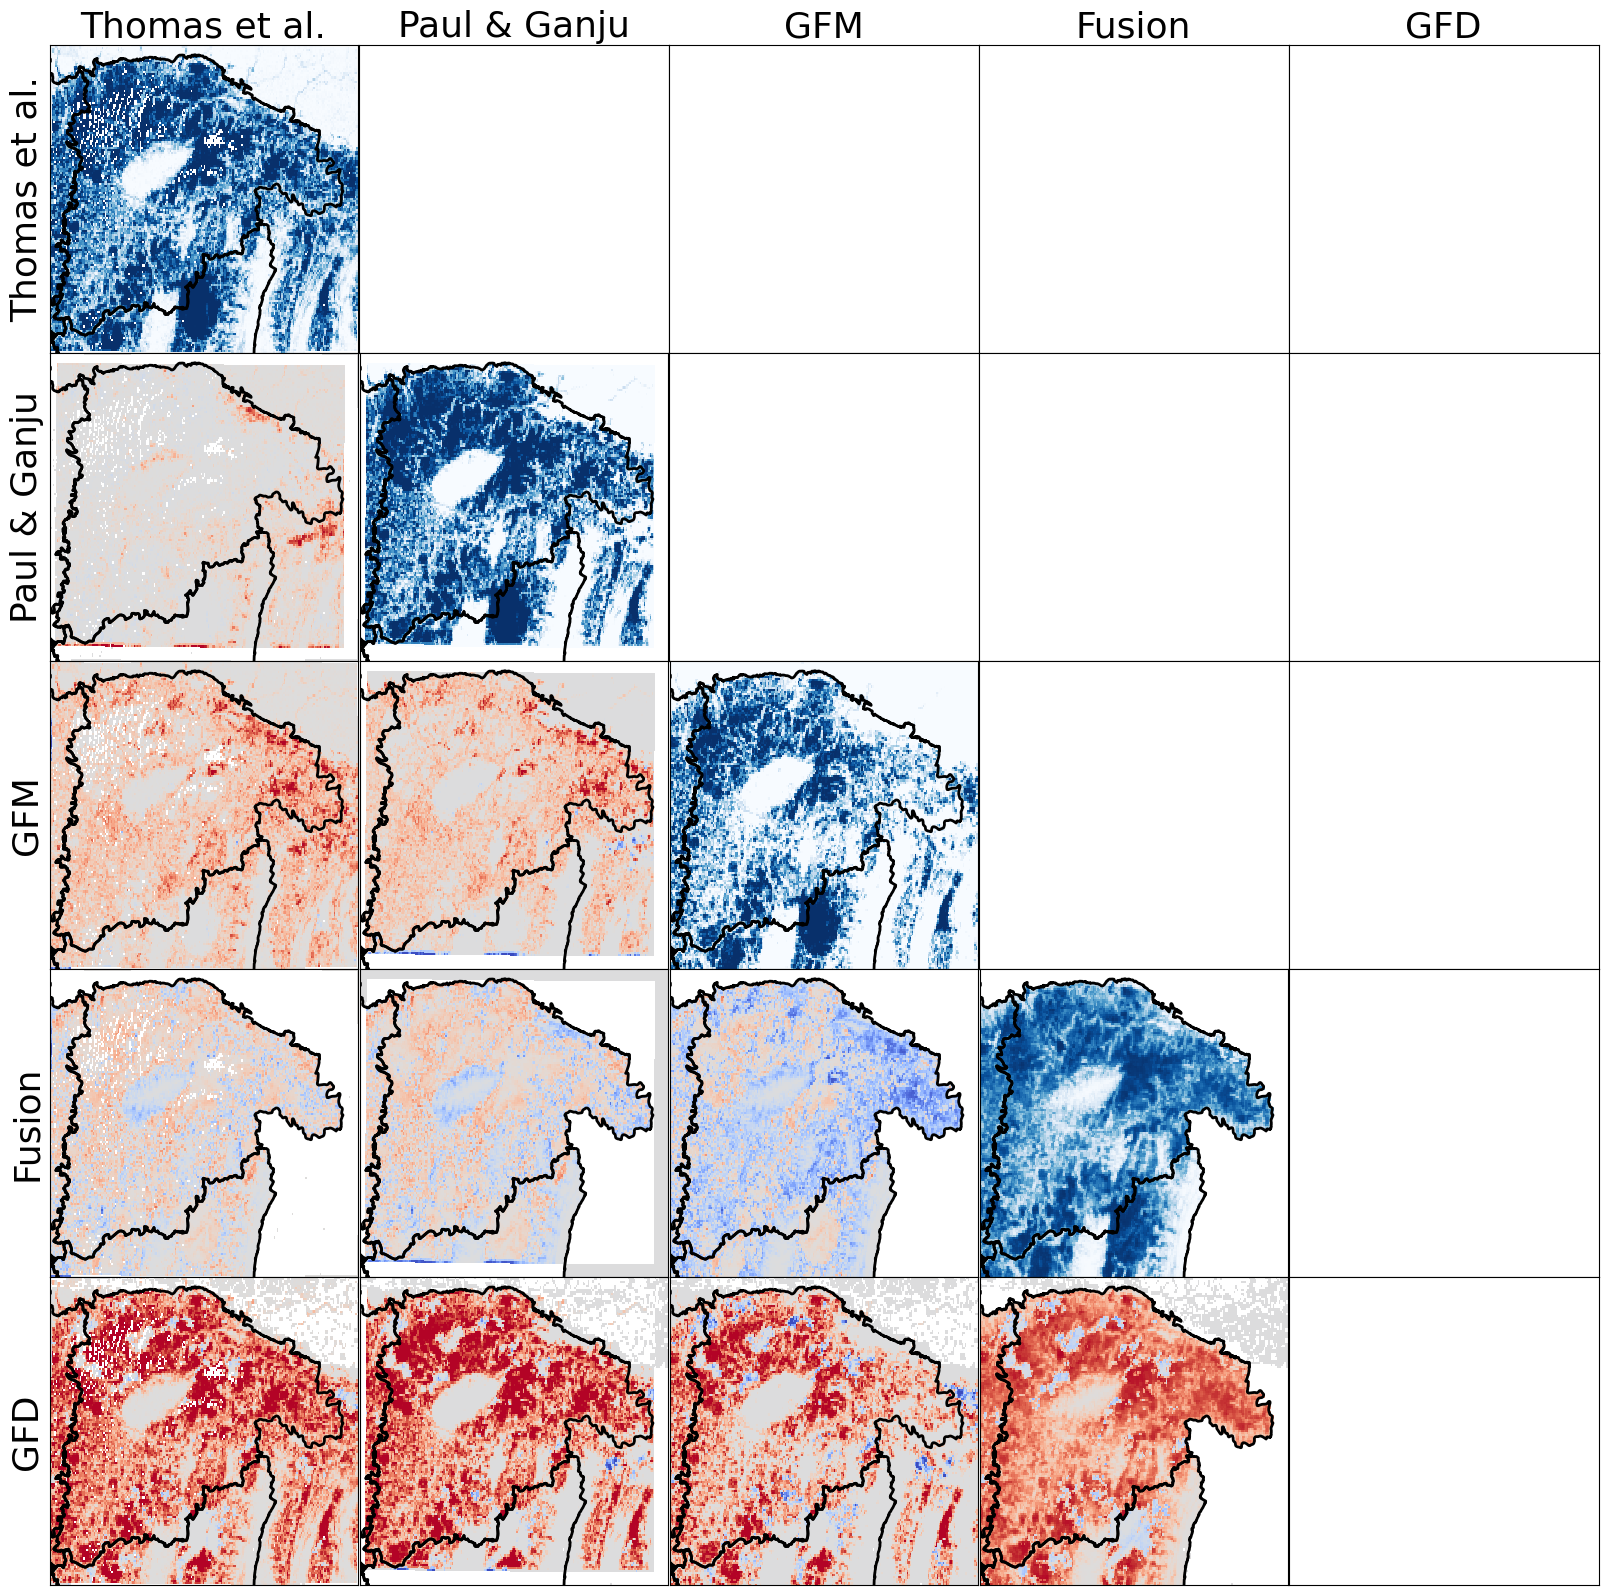

In [27]:
fig, axes = plt.subplots(5, 5, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(20,20))

for i, ax in enumerate(axes.ravel()):
    
    # Get the pair of rasters to plot
    dataPair=dataList[i]
    raster1=dataPair[0]
    raster2=dataPair[1]
    
    # Add data to the plots
    
    # Plot the absolute FIA map
    if i in diag[0:-1]: 
        # In the first plot, include coord ticks and scale bar
        plotFIA = visualize_DV.subplotFIAMap(raster1, 'epsg:32646', 'epsg:4326', 0.2, 0.2, ax, cmapFIA, 0, 1, districts, upazillas, ticks=False, sbar=False)
 
#     if i==diag[-1]:
#         plotFIA = visualize_DV.subplotFIAMap(raster1, 'epsg:32646', 'epsg:4326', 0.2, 0.2, ax, cmapFIA, 0, 1, districts, upazillas, ticks=True, sbar=True)
     
                
    # Plot the FIA difference map     
    elif i in lower:
        plotFIADiff = visualize_DV.subplotFIADiffMap(raster1, raster2, ax, cmapFIADiff, -1, 1, districts, upazillas)
        
    
    # # Plot the FIA scatter with regression    
    # elif i in upper: 
    #     visualize_DV.subplotFIAScatter(ax, raster1, raster2)
        
        
    # For upper and left edge plots, include a title for the model
    if i in titlesTop:
        ax.set_title(labelsModels[i], fontsize=26)  
    if i in titlesBot:
        ax.set_ylabel(labelsModels[int(i/5)], fontsize=26)
        
    ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        
    raster1=None
    raster2=None
        
        
# Add legends at bottom of all subplots - one for absolute FIA, one for FIA difference

# Abslute FIA colorbar
# fig.subplots_adjust(bottom=0.08)
# cbar_ax = fig.add_axes([0.15, 0.05, 0.30, 0.02])
# cbar = plt.colorbar(plotFIA, cax=cbar_ax, ticks=[0, 1], orientation='horizontal')
# ticklabs = cbar.ax.get_xticklabels()
# cbar.ax.set_xticklabels(ticklabs, fontsize=22)
# cbar.ax.set_xlabel('Fractional Inundated Area (500 m)', fontsize=26)

# # FIA difference colorbar
# cbar_ax2 = fig.add_axes([0.55, 0.05, 0.30, 0.02])
# cbar2 = plt.colorbar(plotFIADiff, cax=cbar_ax2, ticks=[-1, 0, 1], orientation='horizontal')
# ticklabs2 = cbar2.ax.get_xticklabels()
# cbar2.ax.set_xticklabels(ticklabs2, fontsize=22)
# cbar2.ax.set_xlabel('Difference in Fractional Inundated Area', fontsize=26)

plt.show()

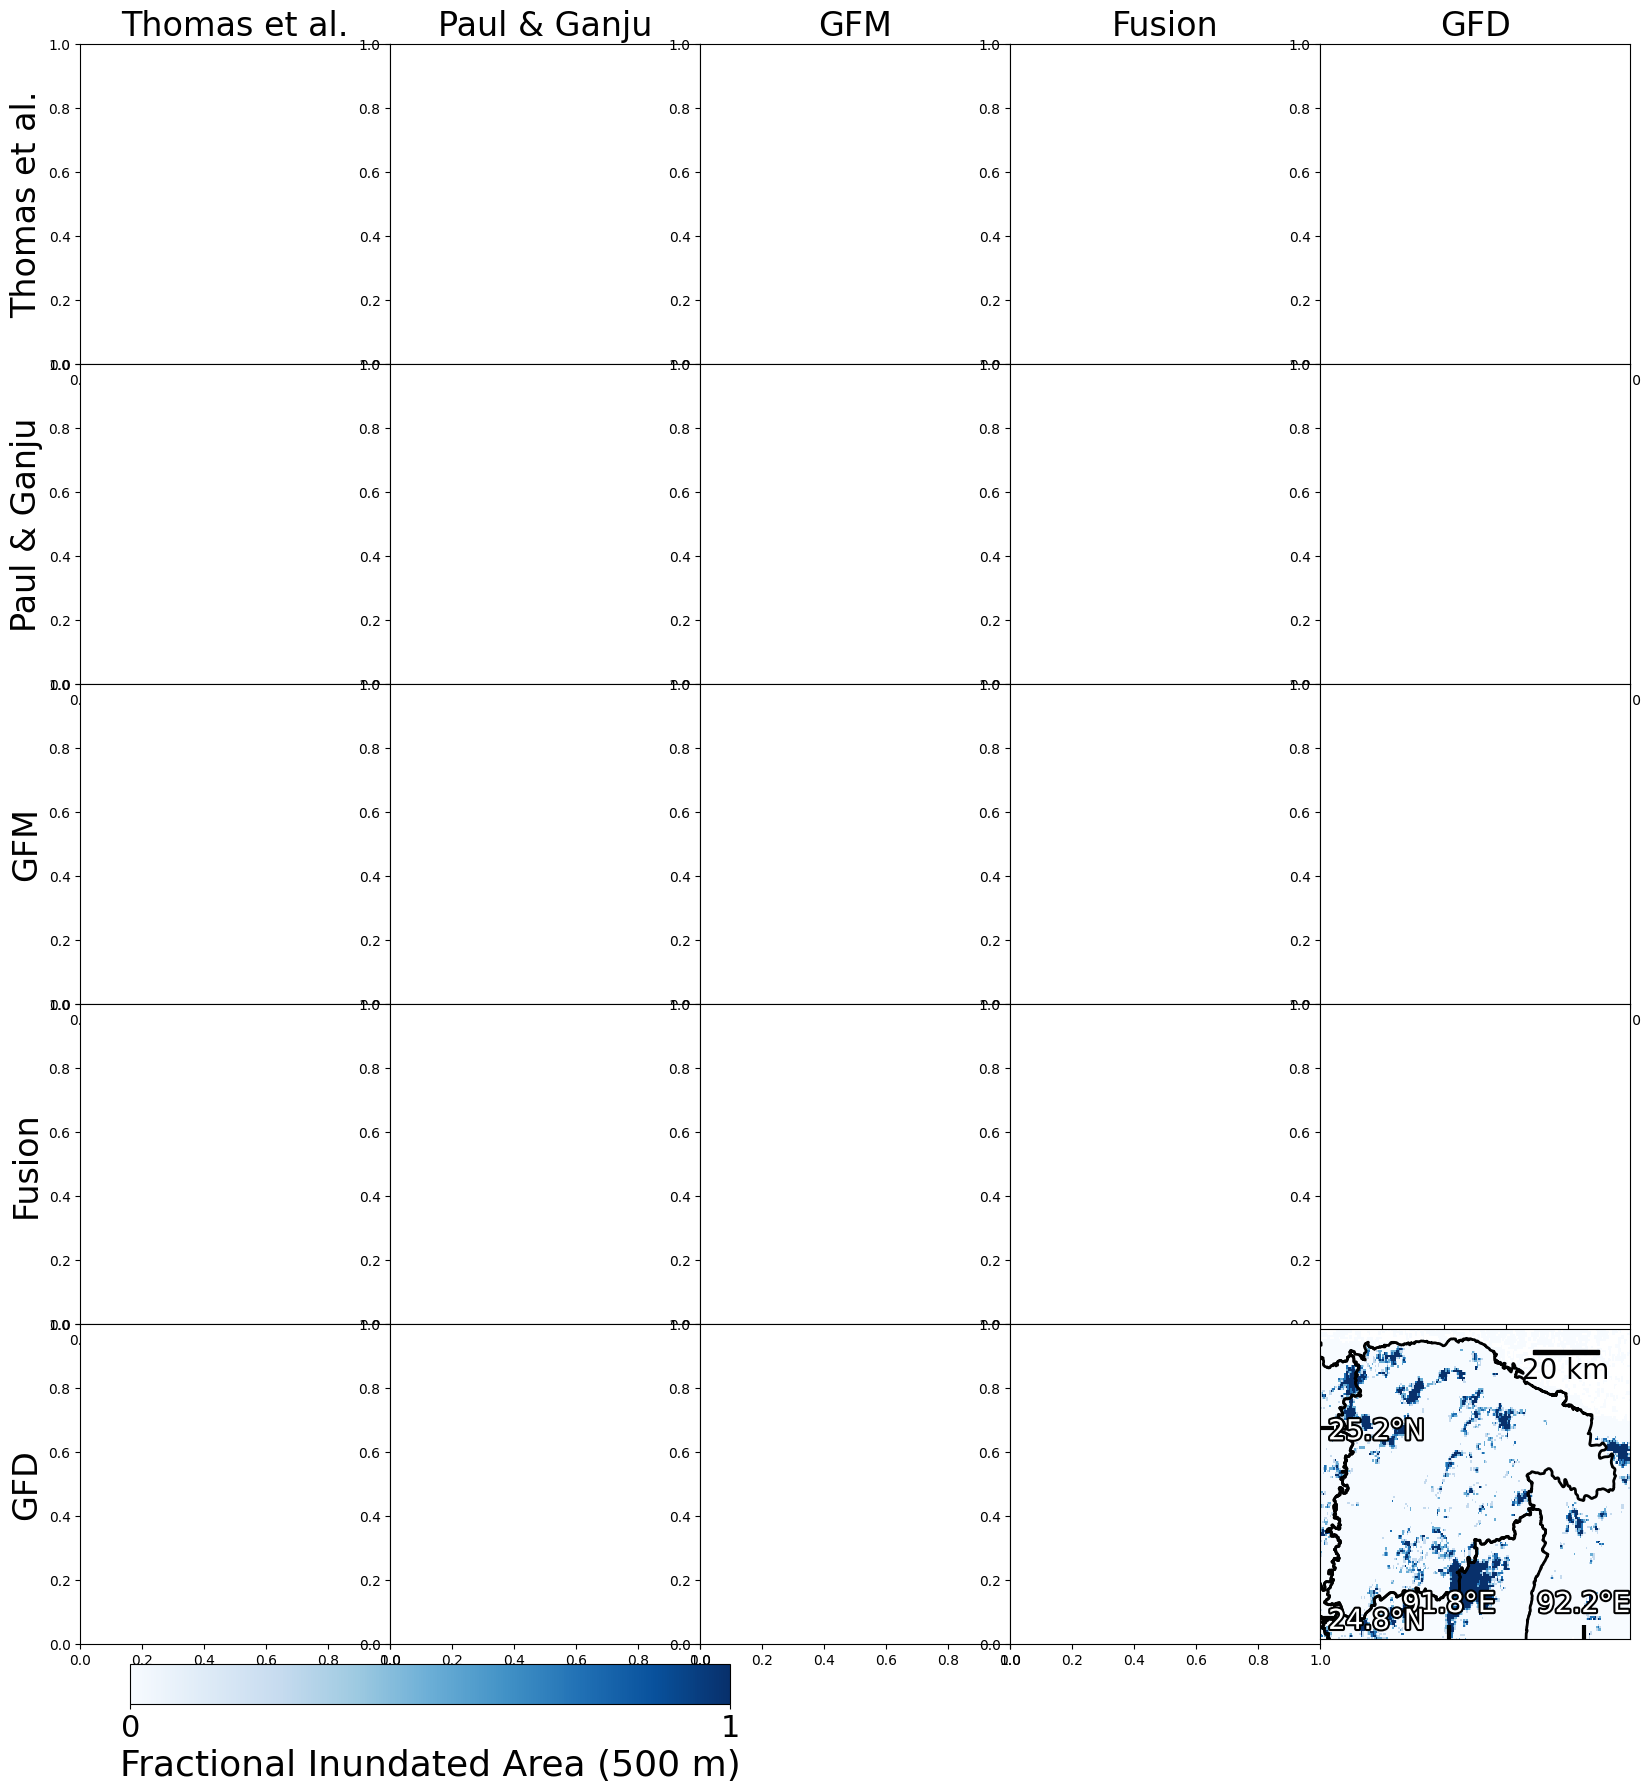

In [25]:
fig, axes = plt.subplots(5, 5, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(20,20))

for i, ax in enumerate(axes.ravel()):
    
    # Get the pair of rasters to plot
    dataPair=dataList[i]
    raster1=dataPair[0]
    raster2=dataPair[1]
    
    # Add data to the plots
    
    # Plot the absolute FIA map
#     if i in diag[0:-1]: 
#         # In the first plot, include coord ticks and scale bar
#         plotFIA = visualize_DV.subplotFIAMap(raster1, 'epsg:32646', 'epsg:4326', 0.2, 0.2, ax, cmapFIA, 0, 1, districts, upazillas, ticks=False, sbar=False)
 
    if i==diag[-1]:
        plotFIA = visualize_DV.subplotFIAMap(raster1, 'epsg:32646', 'epsg:4326', 0.2, 0.2, ax, cmapFIA, 0, 1, districts, upazillas, ticks=True, sbar=True)
     
                
#     # Plot the FIA difference map     
#     elif i in lower:
#         plotFIADiff = visualize_DV.subplotFIADiffMap(raster1, raster2, ax, cmapFIADiff, -1, 1, districts, upazillas)
        
    
    # # Plot the FIA scatter with regression    
    # elif i in upper: 
    #     visualize_DV.subplotFIAScatter(ax, raster1, raster2)
        
        
    # For upper and left edge plots, include a title for the model
    if i in titlesTop:
        ax.set_title(labelsModels[i], fontsize=24)  
    if i in titlesBot:
        ax.set_ylabel(labelsModels[int(i/5)], fontsize=24)
        
    raster1=None
    raster2=None
        
        
# Add legends at bottom of all subplots - one for absolute FIA, one for FIA difference

# Abslute FIA colorbar
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.15, 0.05, 0.30, 0.02])
cbar = plt.colorbar(plotFIA, cax=cbar_ax, ticks=[0, 1], orientation='horizontal')
ticklabs = cbar.ax.get_xticklabels()
cbar.ax.set_xticklabels(ticklabs, fontsize=22)
cbar.ax.set_xlabel('Fractional Inundated Area (500 m)', fontsize=26)

# # FIA difference colorbar
# cbar_ax2 = fig.add_axes([0.55, 0.05, 0.30, 0.02])
# cbar2 = plt.colorbar(plotFIADiff, cax=cbar_ax2, ticks=[-1, 0, 1], orientation='horizontal')
# ticklabs2 = cbar2.ax.get_xticklabels()
# cbar2.ax.set_xticklabels(ticklabs2, fontsize=22)
# cbar2.ax.set_xlabel('Difference in Fractional Inundated Area', fontsize=26)

plt.show()

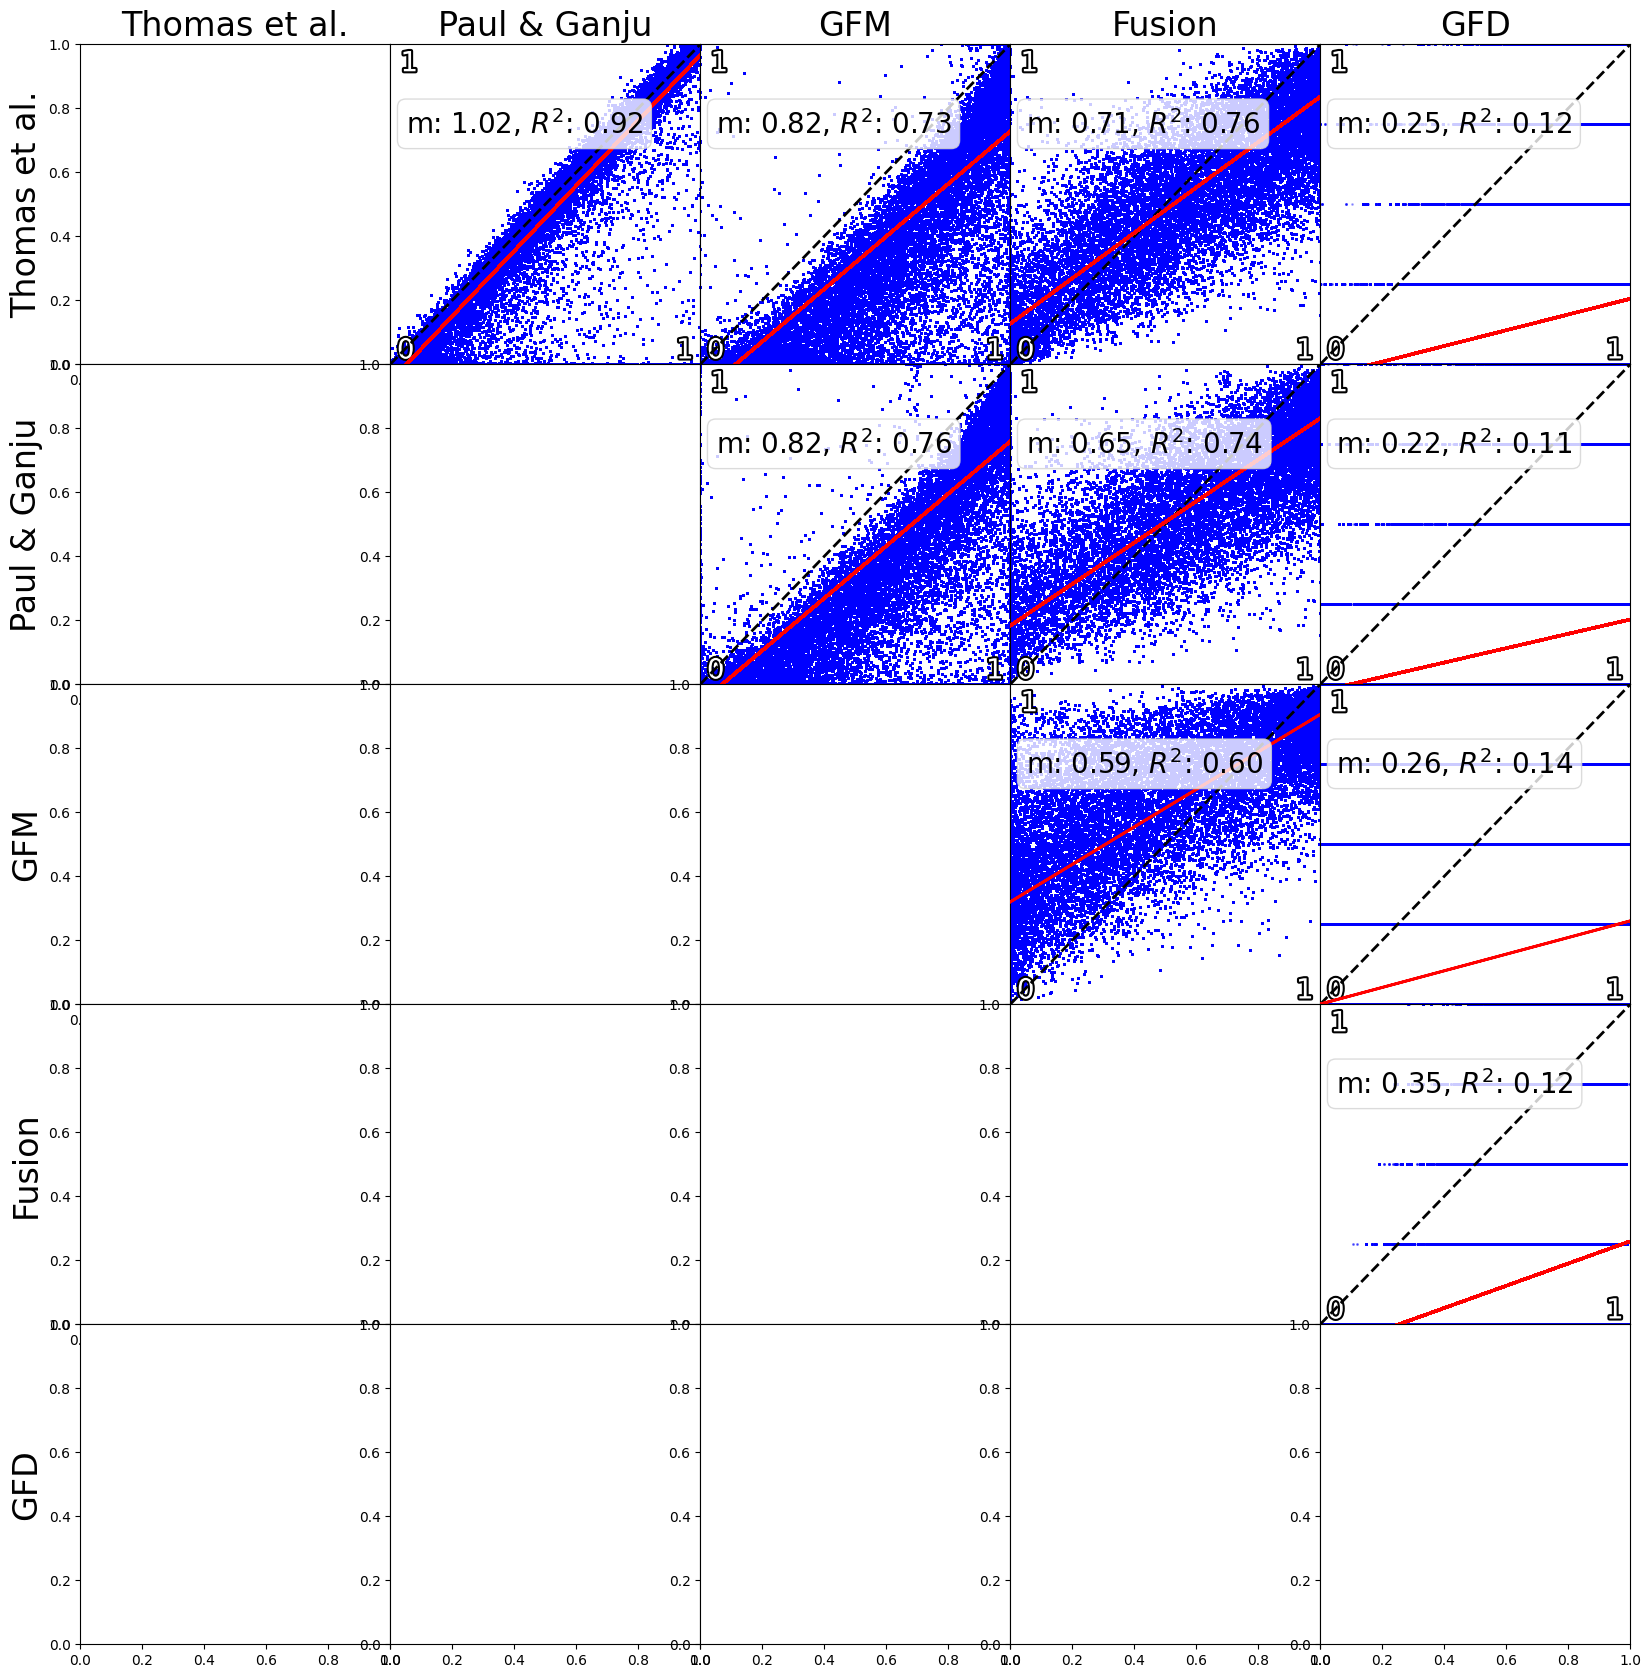

In [21]:
fig, axes = plt.subplots(5, 5, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(20,20))

for i, ax in enumerate(axes.ravel()):
    
    # Get the pair of rasters to plot
    dataPair=dataList[i]
    raster1=dataPair[0]
    raster2=dataPair[1]
    
    # Add data to the plots
    
    # Plot the absolute FIA map
#     if i in diag: 
#         # In the first plot, include coord ticks and scale bar
#         plotFIA = visualize_DV.subplotFIAMap(raster1, 'epsg:32646', 'epsg:4326', 0.2, 0.2, ax, cmapFIA, 0, 1, districts, upazillas, ticks=False, sbar=False)
 
#     elif i==diag[-1]:
#         plotFIA = visualize_DV.subplotFIAMap(raster1, 'epsg:32646', 'epsg:4326', 0.2, 0.2, ax, cmapFIA, 0, 1, districts, upazillas, ticks=True, sbar=True)
     
                
#     # Plot the FIA difference map     
#     elif i in lower:
#         plotFIADiff = visualize_DV.subplotFIADiffMap(raster1, raster2, ax, cmapFIADiff, -1, 1, districts, upazillas)
        
    
    # Plot the FIA scatter with regression    
    if i in upper: 
        visualize_DV.subplotFIAScatter(ax, raster1, raster2)
        
        
    # For upper and left edge plots, include a title for the model
    if i in titlesTop:
        ax.set_title(labelsModels[i], fontsize=26)  
    if i in titlesBot:
        ax.set_ylabel(labelsModels[int(i/5)], fontsize=26)
        
    raster1=None
    raster2=None
        
        
# Add legends at bottom of all subplots - one for absolute FIA, one for FIA difference

# Abslute FIA colorbar
fig.subplots_adjust(bottom=0.08)
# cbar_ax = fig.add_axes([0.15, 0.05, 0.30, 0.02])
# cbar = plt.colorbar(plotFIA, cax=cbar_ax, ticks=[0, 1], orientation='horizontal')
# ticklabs = cbar.ax.get_xticklabels()
# cbar.ax.set_xticklabels(ticklabs, fontsize=22)
# cbar.ax.set_xlabel('Fractional Inundated Area (500 m)', fontsize=26)

# # FIA difference colorbar
# cbar_ax2 = fig.add_axes([0.55, 0.05, 0.30, 0.02])
# cbar2 = plt.colorbar(plotFIADiff, cax=cbar_ax2, ticks=[-1, 0, 1], orientation='horizontal')
# ticklabs2 = cbar2.ax.get_xticklabels()
# cbar2.ax.set_xticklabels(ticklabs2, fontsize=22)
# cbar2.ax.set_xlabel('Difference in Fractional Inundated Area', fontsize=26)

plt.show()